### Import modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from ensemble_outlier_sample_detection import EnsembleOutlierSampleDetector
import matplotlib.pyplot as plt
import seaborn as sns

### Define some constants

In [2]:
SEED = 334
n_splits = 5
kf = KFold(n_splits = n_splits, shuffle =True, random_state = SEED)

### Load dataset
Use a dataset where some of the `y` values are strange.  

Original data: https://github.com/hkaneko1985/ensemble_outlier_sample_detection  
(Used under the MIT License)

In [3]:
example_path = 'example_chache.csv'
df = pd.read_csv(example_path, index_col = 0, comment='#')
X = df.iloc[:, 1:]
y = df.iloc[:, 0]
display(X.head(), y.head())

x1        x2        x3        x4        x5        x6  \
sample_1 -0.008829  0.020603  0.012806  0.022196  0.014404  0.000542   
sample_2  0.054267 -0.011827  0.024182  0.010591  0.043688  0.028225   
sample_3  0.007996  0.085998  0.083851  0.068907  0.046763  0.029664   
sample_4  0.007808  0.058072  0.071922  0.075210  0.070864  0.041052   
sample_5  0.025469  0.069069  0.039437  0.035413  0.026697  0.018137   

                x7        x8        x9       x10  
sample_1 -0.017258  0.035589  0.002711 -0.005959  
sample_2 -0.026693  0.002172  0.036835 -0.030305  
sample_3  0.023624  0.026716  0.005059  0.018760  
sample_4  0.031952  0.061823  0.032988 -0.028616  
sample_5  0.024466  0.064571  0.043171  0.033427

sample_1    4.862230
sample_2    4.979903
sample_3    5.068076
sample_4    5.166788
sample_5    5.374128
Name: y, dtype: float64

### Use `pairplot` to visually check the distribution
Correlation between `y` and other variables shows that there is a deviant population.

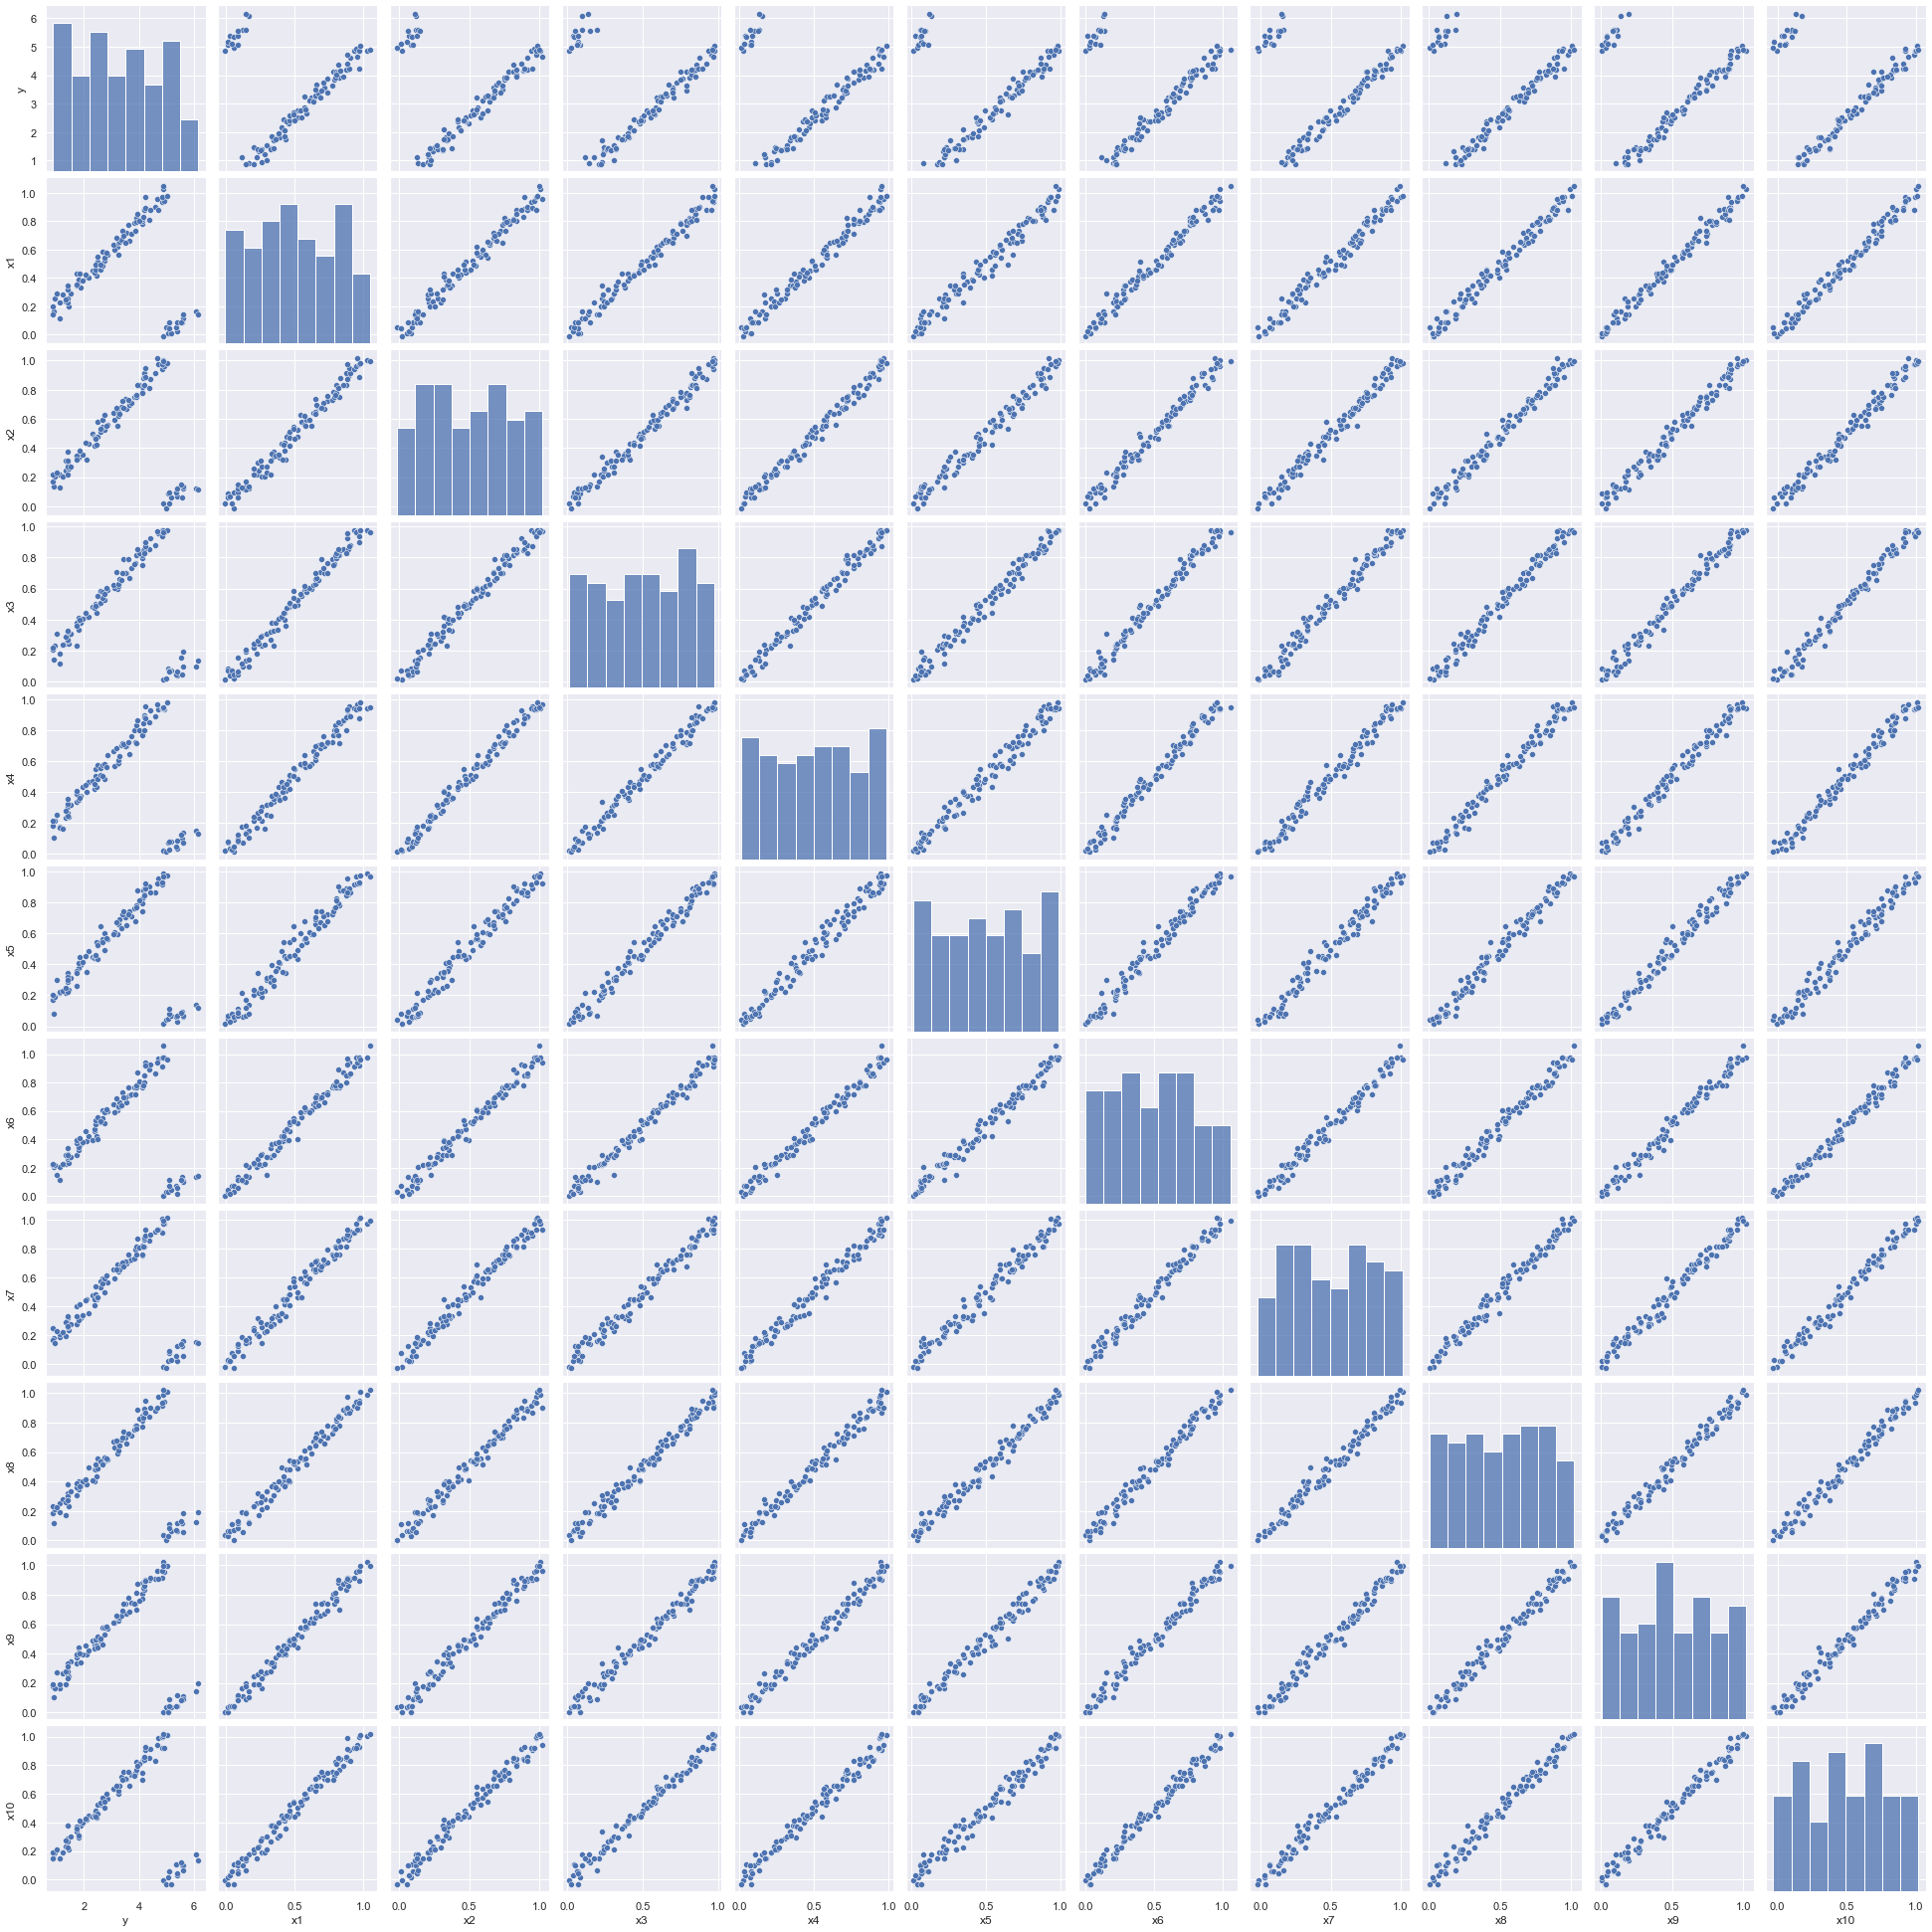

In [4]:
sns.set(style = 'darkgrid')
sns.pairplot(data = df)

### Define RandomForest estimator

In [5]:
rf = RandomForestRegressor(n_jobs = -1, random_state = SEED)

### Not ELO
#### Prediction
Cross Validation

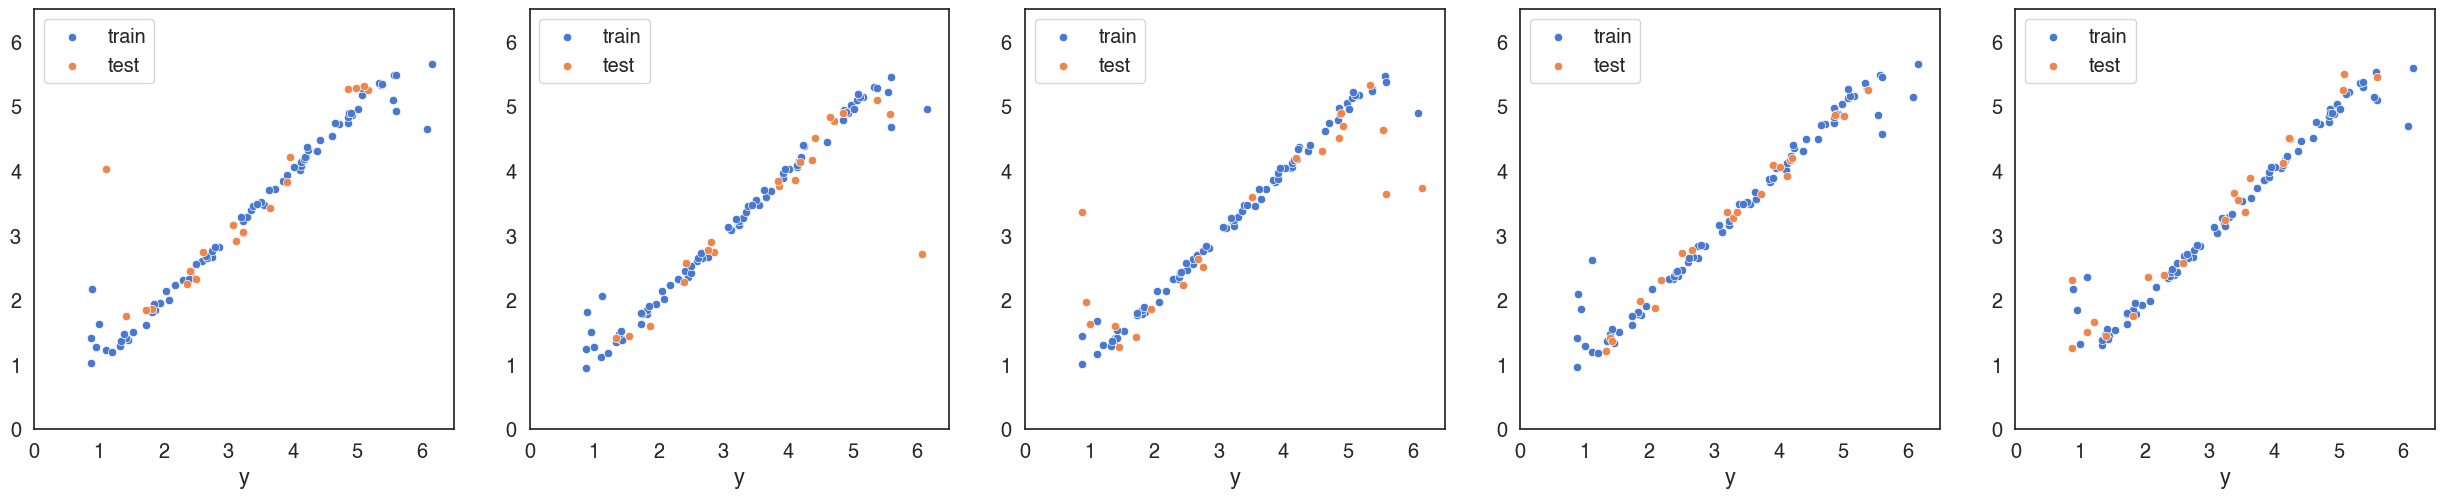

In [6]:
score_names = ['RMSE', 'MAE', 'R2']
data_names = ['train', 'test']
metrics = dict(zip(score_names, [lambda y1, y2: mean_squared_error(y1, y2, squared = False), mean_absolute_error, r2_score]))
scores = {data_name: {score_name: [] for score_name in score_names} for data_name in data_names}

sns.reset_defaults()
sns.set(style = 'white', palette = 'muted', font = 'Helvetica', font_scale = 1.3)
fig = plt.figure(facecolor = 'white', figsize = (5*n_splits, 5))
for j, (i_train, i_test) in enumerate(kf.split(X, y)):
    ax = fig.add_subplot(1, n_splits, j+1)

    X_train, X_test, y_train, y_test = X.iloc[i_train], X.iloc[i_test], y[i_train], y[i_test]

    rf.fit(X_train, y_train)

    y_pred_on_train = rf.predict(X_train)
    y_pred_on_test = rf.predict(X_test)

    sns.scatterplot(x=y_train, y=y_pred_on_train, ax = ax, label = 'train')
    sns.scatterplot(x=y_test, y=y_pred_on_test, ax = ax, label = 'test')

    ax.set_xlim(0, 6.5)
    ax.set_ylim(0, 6.5)

    ax.set_aspect('equal')

    for score_name, metric in metrics.items():
        scores['train'][score_name].append(metric(y_pred_on_train, y_train))
        scores['test'][score_name].append(metric(y_pred_on_test, y_test))
fig.tight_layout()

### Scores

In [7]:
for data_name in data_names:
    for score_name in score_names:
        print('{1}({0}):\t{2:.3f}'.format(data_name, score_name, np.average(scores[data_name][score_name])))

RMSE(train):	0.259
MAE(train):	0.118
R2(train):	0.961
RMSE(test):	0.590
MAE(test):	0.314
R2(test):	0.720


### ELO

In [8]:
elo = EnsembleOutlierSampleDetector(random_state = SEED, n_jobs = -1, cv = 5, metric = 'rmse')
elo.fit(X, y)

  0%|          | 0/3000 [00:00<?, ?it/s]

#### Extract

In [9]:
flags = elo.get_inlier_support()
X_normal = X.loc[flags]
y_normal = y[flags]

#### pairplot
You will see that the outlier samples have been removed.

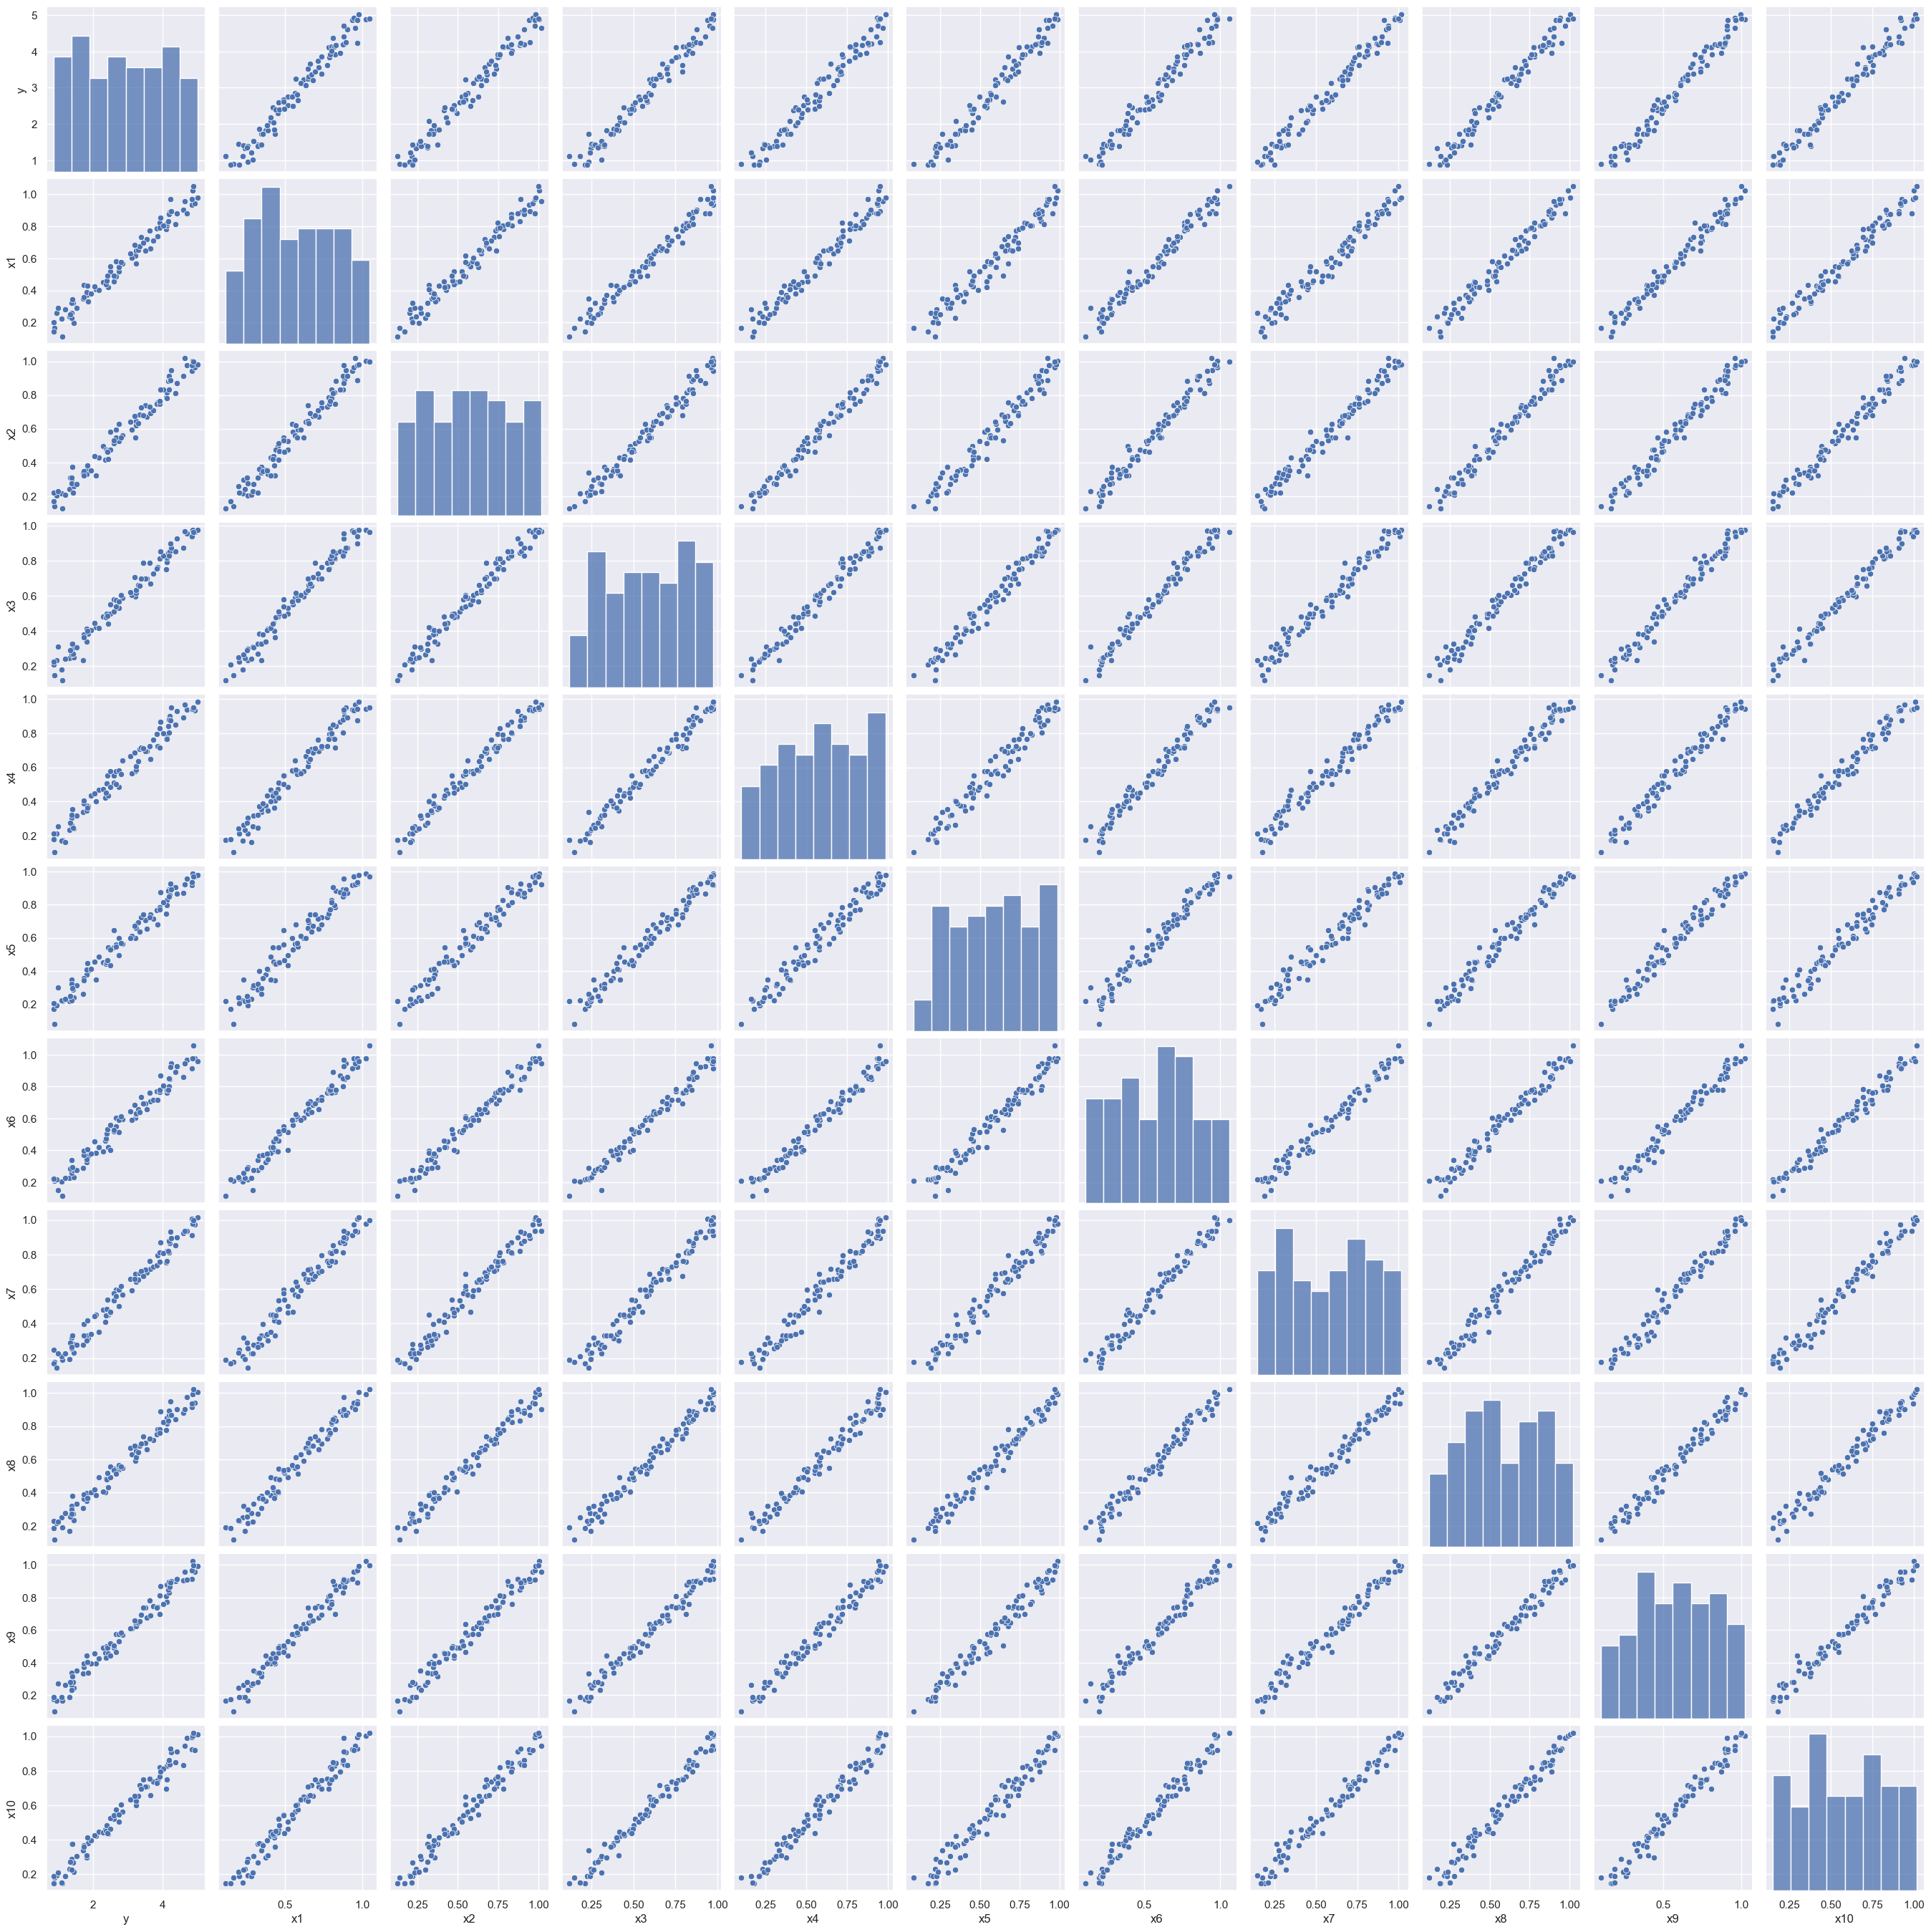

In [10]:
sns.reset_defaults()
sns.set(style = 'darkgrid')
sns.pairplot(data = pd.concat([y_normal, X_normal], axis = 1))

#### Predict

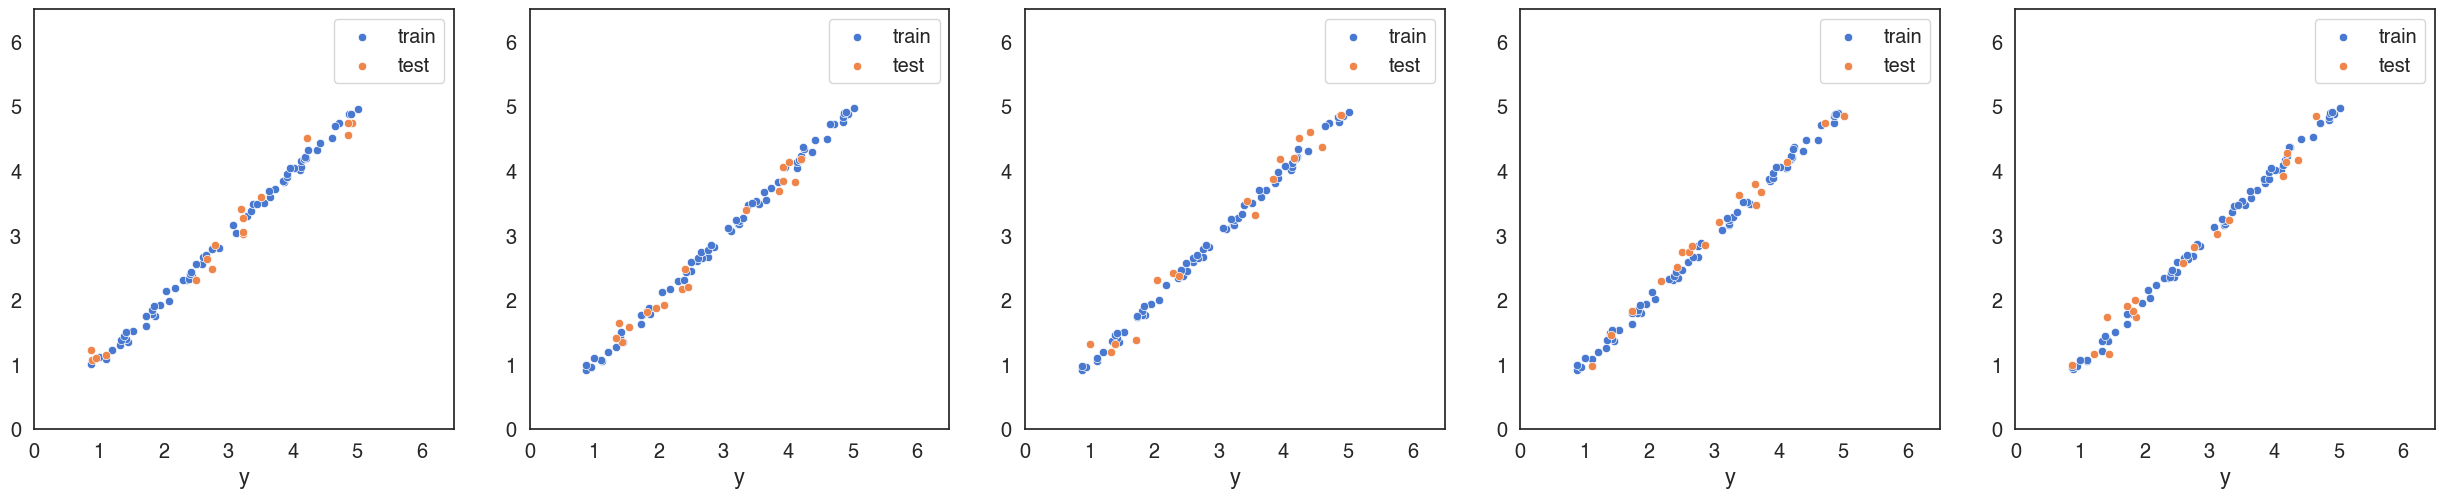

In [11]:
score_names = ['RMSE', 'MAE', 'R2']
data_names = ['train', 'test']
metrics = dict(zip(score_names, [lambda y1, y2: mean_squared_error(y1, y2, squared = False), mean_absolute_error, r2_score]))
scores = {data_name: {score_name: [] for score_name in score_names} for data_name in data_names}

sns.reset_defaults()
sns.set(style = 'white', palette = 'muted', font = 'Helvetica', font_scale = 1.3)
fig = plt.figure(facecolor = 'white', figsize = (5*n_splits, 5))
for j, (i_train, i_test) in enumerate(kf.split(X_normal, y_normal)):
    ax = fig.add_subplot(1, n_splits, j+1)

    X_train, X_test, y_train, y_test = X_normal.iloc[i_train], X_normal.iloc[i_test], y_normal[i_train], y_normal[i_test]

    rf.fit(X_train, y_train)

    y_pred_on_train = rf.predict(X_train)
    y_pred_on_test = rf.predict(X_test)

    sns.scatterplot(x=y_train, y=y_pred_on_train, ax = ax, label = 'train')
    sns.scatterplot(x=y_test, y=y_pred_on_test, ax = ax, label = 'test')

    ax.set_xlim(0, 6.5)
    ax.set_ylim(0, 6.5)

    ax.set_aspect('equal')

    for score_name, metric in metrics.items():
        scores['train'][score_name].append(metric(y_pred_on_train, y_train))
        scores['test'][score_name].append(metric(y_pred_on_test, y_test))
fig.tight_layout()

#### Scores

In [12]:
for data_name in data_names:
    for score_name in score_names:
        print('{1}({0}):\t{2:.3f}'.format(data_name, score_name, np.average(scores[data_name][score_name])))

RMSE(train):	0.060
MAE(train):	0.050
R2(train):	0.998
RMSE(test):	0.166
MAE(test):	0.140
R2(test):	0.980
